# BLU06  - Exercise Notebook 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
idx = pd.IndexSlice
warnings.simplefilter(action='ignore', category=FutureWarning)   
from random import seed
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
import math
from sklearn.ensemble import GradientBoostingRegressor
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
import hashlib # for grading purposes
from sklearn.model_selection import ParameterGrid

from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
plt.rcParams['figure.figsize'] = (12, 4)

%matplotlib inline

# Functions

These functions will be necessary for the exercises. The only one you'll use is _predict_n_periods_. The others are used by the latter.

In [2]:
def build_target(series_, number_of_periods_ahead):
    """ 
    takes a series, turned it into a dataframe, and adds a new column called target
    This column is the input series, lagged number_of_periods_ahead into the future
    """
    
    # make a copy 
    series_ = series_.copy()
    series_.name = 'customers'
    
    # make a dataframe from the series
    df_ = pd.DataFrame(series_)
    
    # the target column will be the input series, lagged into the future
    df_['target'] = series_.shift(-number_of_periods_ahead)
    return df_

In [3]:
def separate_last_day(df_):
    
    """
    takes a dataset which has the target and features built 
    and separates it into the last day
    """
    # take the last period 
    last_period = df_.iloc[-1]
    
    # the last period is now a series, so it's name will be the timestamp
    training_data = df_.loc[df_.index < last_period.name]

    return last_period, training_data

In [4]:
def build_some_features(df_, num_periods_lagged=1, num_periods_diffed=0, weekday=False, month=False, rolling=[], holidays=False): 
    """
    Builds some features by calculating differences between periods  
    """
    # make a copy 
    df_ = df_.copy()
        
    # for a few values, get the lags  
    for i in range(1, num_periods_lagged+1):
        # make a new feature, with the lags in the observed values column
        df_['lagged_%s' % str(i)] = df_['customers'].shift(i)
        
    # for a few values, get the diffs  
    for i in range(1, num_periods_diffed+1):
        # make a new feature, with the lags in the observed values column
        df_['diff_%s' % str(i)] = df_['customers'].diff(i)
    
    for stat in rolling:
        df_['rolling_%s'%str(stat)] = df_['customers'].rolling('7D').aggregate(stat)
        
    if weekday == True:
        df_['sin_weekday'] = np.sin(2*np.pi*df_.index.weekday/7)
        df_['cos_weekday'] = np.sin(2*np.pi*df_.index.weekday/7)
        
    if month == True:
        df_['sin_month'] = np.sin(2*np.pi*df_.index.month/12)
        df_['cos_month'] = np.sin(2*np.pi*df_.index.month/12)
        
    if holidays == True:
        holidays = df_[((df_.index.month==12) & (df_.index.day==25))
              |((df_.index.month==1) & (df_.index.day==1))].customers
        df_['holidays'] = holidays + 1
        df_['holidays'] = df_['holidays'].fillna(0)
    
    return df_

In [5]:
def separate_train_and_test_set(last_period_, training_data_, target='target'): 
    
    """ 
    separates training and test set (clue was in the name, really... )
    Ok, we were lazy and left the target hardcoded as 'target'. Shame on us. 
    """
    
    # anything that isn't a target is a feature 
    features = [feature for feature in training_data_.columns if feature != target]
    
    # adding a sneaky little dropna to avoid the missing data problem above 
    X_train = training_data_.dropna()[features]
    y_train = training_data_.dropna()[target]
    
    X_last_period = last_period_[features]
    
    return X_train, y_train, X_last_period

In [6]:
def prepare_for_prediction(series_, number_of_periods_ahead, num_periods_lagged, num_periods_diffed, weekday, month, rolling, holidays):
    
    """ 
    Wrapper to go from the original series to X_train, y_train, X_last_period 
    
    """
    
    # build the target 
    data_with_target = build_target(series_, 
                                    number_of_periods_ahead)
    
    # build the features 
    data_with_target_and_features = build_some_features(data_with_target, 
                                                        num_periods_lagged=num_periods_lagged,
                                                       num_periods_diffed=num_periods_diffed,
                                                       weekday=weekday,
                                                       month=month,
                                                       rolling=rolling,
                                                       holidays=holidays)
    # separate train and test data 
    last_period, training_data = separate_last_day(data_with_target_and_features)

    # separate X_train, y_train, and X_test 
    X_train, y_train, X_last_period = separate_train_and_test_set(last_period, 
                                                           training_data, 
                                                           target='target')
    
    # return ALL OF THE THINGS! (well, actually just the ones we need)
    return X_train, y_train, X_last_period 

In [7]:
def predict_period_n(series_, model, number_of_periods_ahead, num_periods_lagged, num_periods_diffed, weekday, month, rolling, holidays): 
    
        X_train, y_train, X_last_period = prepare_for_prediction(series_, 
                                                             number_of_periods_ahead, 
                                                             num_periods_lagged,
                                                             num_periods_diffed,
                                                             weekday,
                                                             month,
                                                             rolling,
                                                             holidays)
        
        model.fit(X_train, y_train)
        return model.predict(X_last_period.values.reshape(1, -1))

In [8]:
def predict_n_periods(series_, n_periods, model, num_periods_lagged, num_periods_diffed=0, weekday=False, month=False,rolling=[], holidays=False): 
    predictions = []

    for period_ahead in range(1, n_periods+1):
        pred = predict_period_n(series_=series_, 
                                model=model, 
                                number_of_periods_ahead=period_ahead, 
                                num_periods_lagged=num_periods_lagged,
                                num_periods_diffed=num_periods_diffed,
                                weekday=weekday,
                                month=month,
                                rolling=rolling,
                                holidays=holidays)
        
        predictions.append(pred[0])
        
    return predictions 

# Let's predict store customers!

In [9]:
store = pd.read_csv('data/stores_exercise.csv')
store['date'] = pd.to_datetime(store['date'])
store = store.set_index('date')
store = store.sort_index()
store = store[:-180]

In [10]:
store

,customers
date,
2013-01-02,1903
2013-01-03,1740
2013-01-04,1642
2013-01-05,1643
2013-01-06,1754
...,...
2015-06-29,1403
2015-06-30,1393
2015-07-01,1517


##### Plot the series to get an idea of what's going on

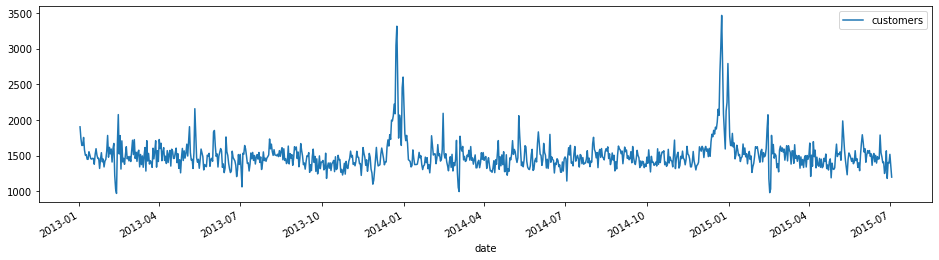

In [11]:
store.plot(figsize=(16, 4));

### Q1: Are there any missing days in the time series? If so, inspect them and decide how to fill them.

In [12]:
# hint1: if the missing dates are holidays you can fill them with 0, since that's
# indication that the store was closed.

# hint2: the missing_value_mask should be a boolean Pandas Series with True or False according to if the value
# missing or not.

# hint3: the missing_value_dates should be a DatetimeIndex with the dates with missing values.

store_resampled = store.resample('D').mean()
missing_value_mask = store_resampled.isnull()['customers']
#missing_value_dates =store_resampled[missing_value_mask]
missing_value_dates =store_resampled[missing_value_mask].index
store_cleaned = store_resampled.fillna(0)
# YOUR CODE HERE
#raise NotImplementedError()
store_cleaned

,customers
date,
2013-01-02,1903.0
2013-01-03,1740.0
2013-01-04,1642.0
2013-01-05,1643.0
2013-01-06,1754.0
...,...
2015-06-29,1403.0
2015-06-30,1393.0
2015-07-01,1517.0


In [13]:
expected_hash = 'e9f26ecc6d60870d336e555719e6024c19a07e62c9e7174c36c42b847d50936a'
assert hashlib.sha256(str(missing_value_dates).encode()).hexdigest() == expected_hash

expected_hash = '5ddd3f2573d5c72b9718a3626e6478ec5f7f68f572e36dd3752cb962bf8602a5'
assert hashlib.sha256(str(store_cleaned).encode()).hexdigest() == expected_hash

### Q2: Formulate it as time series one-step-ahead prediction

### Q2.1 Create the target, the lags and drop the missing values.

,customers
date,
2013-01-02,1903.0
2013-01-03,1740.0
2013-01-04,1642.0
2013-01-05,1643.0
2013-01-06,1754.0
...,...
2015-06-29,1403.0
2015-06-30,1393.0
2015-07-01,1517.0


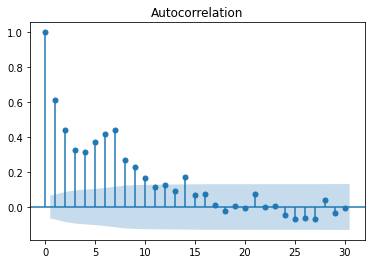

In [14]:
# Note: You should add as features the top 5 lags. To do that, look a the ACF of the time series and chose
# Remember from the previous BLU to look at the ACF you only need to run plot_acf(store)
# the top5 most correlated lags.
plot_acf(store)

store_features = store_cleaned.copy()
store_features['lag_a'] = store_features.customers.shift(+1)
store_features['lag_b'] = store_features.customers.shift(+2)
store_features['lag_c'] = store_features.customers.shift(+5)
store_features['lag_d'] = store_features.customers.shift(+6)
store_features['lag_e'] = store_features.customers.shift(+7)
store_features['target'] =store_features.customers.shift(-1)
store_features = store_features.loc['2013-01-09':'2015-07-02',:]
store_cleaned
# YOUR CODE HERE
#raise NotImplementedError()

In [15]:
expected_hash = '87d487ce996d6bdbf2f7f919c5c40afc5ab52775f9ddb4798572c3d32e585699'
assert hashlib.sha256(str(store_features.shape).encode()).hexdigest() == expected_hash

expected_hash = '33f8d758034dda4da49f9060da8a1870a17e39738a0a6c891ed0d76e5dbdff8c'
assert hashlib.sha256(str(store_features.iloc[0]).encode()).hexdigest() == expected_hash

### Q2.2 Separate the training and test set. The test set consists of the last 60 values, while the training set consists of the rest.

In [16]:
# note: this is a very straightforward question. But you may think: "isn't this one-step-ahead forecasting? 
# Why does the test have 60 values" Well, basically this just means we are doing 60 one-step-ahead forecasts.
# This way we obtain a better estimate of how our one-step-ahead model would perform in real life.

#X_train, y_train, X_last_period=separate_train_and_test_set(store_features.iloc[-1], store_features.iloc[-61::-1,:], target='target')
store_train =store_features.iloc[-61::-1,:].sort_index()
store_test =store_features.iloc[-1:-61:-1,:].sort_index()
# YOUR CODE HERE
#raise NotImplementedError()

In [17]:
expected_hash = '0d597dc2afbcf77932523efe4fa118591cbc3f691191c2471ae95e465c918dd3'
assert hashlib.sha256(str(store_train.index[-1]).encode()).hexdigest() == expected_hash

expected_hash = '23a57d8694a6eb61e0232c384c6939676cf8f8d515298f7f388b9071c22af223'
assert hashlib.sha256(str(store_test.index[0]).encode()).hexdigest() == expected_hash

### Q2.3 Fit a linear regression to the training set

In [18]:
X_store_train = store_train.drop('target',axis = 1)
y_store_train =store_train['target']
model =LinearRegression()
model.fit(X_store_train,y_store_train)

# YOUR CODE HERE
#raise NotImplementedError()

LinearRegression()

In [19]:
expected_hash = 'cc02033f738b18730fa0d433c70f9f93d2db69418fd9a7bb1f3d1cd8683313ba'
assert hashlib.sha256(str(X_store_train.shape).encode()).hexdigest() == expected_hash

expected_hash = '0fabfb9c5d2a657b34aa1ce1474093e522fc2841b3665fdaaabb67e40eddcf44'
assert hashlib.sha256(str(y_store_train.shape).encode()).hexdigest() == expected_hash

expected_hash = '7624371ed342168f5e33937f92ba58381bb3d29a9a904b0e9e48940649c7e0cf'
assert hashlib.sha256(str(np.round(model.coef_,1)).encode()).hexdigest() == expected_hash

### Q2.4 Predict the test set and calculate the MAE

In [20]:
X_store_test = store_test.drop('target',axis = 1)
y_store_test = store_test['target']
y_predict = model.predict(X_store_test)
test_mae = mean_absolute_error(y_store_test,y_predict)

# YOUR CODE HERE
#raise NotImplementedError()

In [21]:
expected_hash = 'eca663a9d471ccdde2af2ff1aafbb6bb843c6ef5e21bebc2321143a8166971a7'
assert hashlib.sha256(str(X_store_test.shape).encode()).hexdigest() == expected_hash

expected_hash = '9053d01727f35cfdbbbd7284dba5e54ee557e5fc33084045dbc6fec2cb8730f7'
assert hashlib.sha256(str(y_store_test.shape).encode()).hexdigest() == expected_hash

expected_hash = '8b940be7fb78aaa6b6567dd7a3987996947460df1c668e698eb92ca77e425349'
assert hashlib.sha256(str(np.int(test_mae)).encode()).hexdigest() == expected_hash

### Q3 Let's go into multi-step prediction!

### Q3.1 Separate the data into train and test. Use the _predict_n_periods_ function to predict 60 steps ahead using linear regression. Then, calculate the MAE for the test set.

In [22]:
# hint: use the cleaned dataset
# Use 7 lags

store_multistep_train = store_cleaned.iloc[-61::-1,:].sort_index()
store_multistep_test = store_cleaned.iloc[-1:-61:-1,:].sort_index()
predictions = predict_n_periods(store_multistep_train,n_periods=60,
                                model=LinearRegression(),num_periods_lagged=7,num_periods_diffed=0,weekday=False, month=False,rolling=[], holidays=False)
test_mae = mean_absolute_error(store_multistep_test,predictions)
#store_multistep_test.shape
#store_cleaned
# YOUR CODE HERE
#raise NotImplementedError()

In [23]:
expected_hash = '299fe0f9c075c40a21029166ce1bd2046db47fcb639a2a13240b5d974961cb0b'
assert hashlib.sha256(str(store_multistep_train.shape).encode()).hexdigest() == expected_hash

expected_hash = '01f6bb906f864c80f90afb9e7d9071b6f6e7222bf67f2de6bce28f55981fbab4'
assert hashlib.sha256(str(store_multistep_test.shape).encode()).hexdigest() == expected_hash

expected_hash = 'f1ee529ef49111208f1c1646c53c8c311c9f093fd7891c1b46d77e98210b018d'
assert hashlib.sha256(str(np.int(predictions[-1])).encode()).hexdigest() == expected_hash

expected_hash = '29db0c6782dbd5000559ef4d9e953e300e2b479eed26d887ef3f92b921c06a67'
assert hashlib.sha256(str(np.int(test_mae)).encode()).hexdigest() == expected_hash

### Q3.2 Separate into train, val and test. Test corresponds to the last 60 values and Val corresponds to the 60 steps before test.

In [24]:
# hint: use the cleaned dataset

store_multistep_train = store_cleaned.iloc[-121::-1,:].sort_index()
store_multistep_val = store_cleaned.iloc[-61:-121:-1,:].sort_index()
store_multistep_test = store_cleaned.iloc[-1:-61:-1,:].sort_index()

# YOUR CODE HERE
#raise NotImplementedError()

In [25]:
expected_hash = '98eb165d180aa2cd9255f5a5151c101fac78fba9ce6c24421daa8b64ca2a0288'
assert hashlib.sha256(str(store_multistep_train.shape).encode()).hexdigest() == expected_hash

expected_hash = '01f6bb906f864c80f90afb9e7d9071b6f6e7222bf67f2de6bce28f55981fbab4'
assert hashlib.sha256(str(store_multistep_val.shape).encode()).hexdigest() == expected_hash

expected_hash = '01f6bb906f864c80f90afb9e7d9071b6f6e7222bf67f2de6bce28f55981fbab4'
assert hashlib.sha256(str(store_multistep_test.shape).encode()).hexdigest() == expected_hash

In [26]:
store_multistep_val.shape

(60, 1)

### Q3.3 Are the holidays, weekday and the month of the year useful features to the model?

In [27]:
%%time

# Create a parameter grid using the gradient boosting regressor as a model. 
# Use 5 lags, zero diffs and no rollings
# For the gradient boosting regressor use n_estimators=20 and random_state=10
# Use a for cycle to find the group of params that minimizes the MAE on the validation set.

# hint: to have no rollings in the predict_n_periods you should send an empty lists of lists: [[]]
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm 
param_grid = {'model':[GradientBoostingRegressor(n_estimators=20,random_state = 10)], 
              'num_periods_lagged':[5],
              'num_periods_diffed':[0],
              'weekday':[True,False],
              'month':[True,False],
              'holidays': [True],
              'rolling' : [[]]
             }

grid = ParameterGrid(param_grid)

error_lst = []

for params in tqdm(grid):
    predictions = predict_n_periods(series_= store_multistep_train, 
                    n_periods=60, 
                      model=params['model'], 
                      num_periods_lagged=params['num_periods_lagged'],
                      num_periods_diffed=params['num_periods_diffed'],
                      weekday=params['weekday'],
                      month=params['month'],
                      rolling=[]
                    )

    error_lst.append(mean_absolute_error(store_multistep_val,predictions))
pd.Series(error_lst).idxmin()

# for params in grid:
     # predictions =
                                    
best_params =list(grid)[0]

# YOUR CODE HERE
#raise NotImplementedError()

100%|██████████| 4/4 [00:13<00:00,  3.33s/it]

CPU times: user 13.3 s, sys: 15.6 ms, total: 13.3 s
Wall time: 13.3 s


In [28]:
expected_hash = '3cbc87c7681f34db4617feaa2c8801931bc5e42d8d0f560e756dd4cd92885f18'
assert hashlib.sha256(str(best_params['weekday']).encode()).hexdigest() == expected_hash

expected_hash = '3cbc87c7681f34db4617feaa2c8801931bc5e42d8d0f560e756dd4cd92885f18'
assert hashlib.sha256(str(best_params['month']).encode()).hexdigest() == expected_hash

expected_hash = '3cbc87c7681f34db4617feaa2c8801931bc5e42d8d0f560e756dd4cd92885f18'
assert hashlib.sha256(str(best_params['holidays']).encode()).hexdigest() == expected_hash

### Q3.4 Train a model with the best combination and predict the test set. Calculate the corresponding MAE.

In [29]:
best_params

{'holidays': True,
 'model': GradientBoostingRegressor(n_estimators=20, random_state=10),
 'month': True,
 'num_periods_diffed': 0,
 'num_periods_lagged': 5,
 'rolling': [],
 'weekday': True}

In [30]:
store_multistep_test.shape

(60, 1)

In [31]:
# For the gradient boosting regressor use n_estimators=20 and random_state=10
# We expect you to train the final model with train and val together.
store_multistep_train_val = store_multistep_train.append(store_multistep_val)
predictions = predict_n_periods(series_= store_multistep_train_val, 
                    n_periods=60, 
                      model=GradientBoostingRegressor(n_estimators=20, random_state=10), 
                      num_periods_lagged=5,
                      num_periods_diffed=0,
                      weekday=True,
                      month=True,
                      rolling=[]
                    )

# predictions = 
test_mae = mean_absolute_error(store_multistep_test,predictions)

# YOUR CODE HERE
#raise NotImplementedError()

In [32]:
expected_hash = '434c9b5ae514646bbd91b50032ca579efec8f22bf0b4aac12e65997c418e0dd6'
assert hashlib.sha256(str(np.int(test_mae)).encode()).hexdigest() == expected_hash